In [1]:
import xarray as xr
import numpy as np
import pandas
from random import sample,choice
from time import time 
import multiprocessing
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
ds_range = xr.open_dataset('data/processed/range-pd-sync3-1.nc')
ds_stream = xr.open_dataset('data/processed/stream-pd-int2.nc')

latitude = ds_range.lat.values
longitude = ds_range.lon.values
t = ds_range.time.values

r_pd = ds_range.pd.values
s_pd = ds_stream.pd.values

In [3]:
r_area = 3.8*3e6 # 3.8 +/- 0.4 km longitude
s_area = 150000

r_power = r_pd*r_area
s_power = s_pd*s_area

In [4]:
not_nan = pandas.read_csv('data/processed/not-nan.csv')
df_idx = list(not_nan.index)

In [5]:
def initialise(N,k):
    '''
    random initial population
    '''
    
    init_pop = np.zeros((N,k),dtype=int)
    
    for i in range(N):
        chrom = np.array(sample(df_idx,k))
        init_pop[i,:] = chrom
    
    return init_pop

In [6]:
def fitness(pop):
    '''
    '''
    
    f_pop = np.zeros((pop.shape[0]))
    
    for i in range(pop.shape[0]):
        df_chrom = not_nan.iloc[pop[i]]
        chrom_pow = np.zeros((pop.shape[1],r_power.shape[0]))
        
        for j in range(pop.shape[1]):
            if df_chrom.iloc[j,0] == 'r':
                chrom_pow[j,:] = r_power[:,df_chrom.iloc[j,1],df_chrom.iloc[j,2]]

            elif df_chrom.iloc[j,0] == 's':
                chrom_pow[j,:] = s_power[:,df_chrom.iloc[j,1],df_chrom.iloc[j,2]]
                
        aggregate = 0
        for j in range(pop.shape[1]):
            aggregate += chrom_pow[j,:]
            
        p_mean = np.mean(aggregate)
        rmsd = np.sqrt(np.mean((aggregate-p_mean)**2))
        f_pop[i] = p_mean/rmsd
        
        
    return f_pop


In [7]:
def selection(pop,f_pop):
    '''
    tournament selection
    '''
    
    num_par = round(0.3*len(f_pop))
    f_idx = list(np.arange(len(f_pop)))
    parents = np.zeros((num_par,pop.shape[1]),dtype=int)
    
    for i in range(num_par):
        t_size = 5 # tournament size
        t_idx = np.array(sample(f_idx,t_size)) # random indices of chromosomes in tournament
        f_max = max(f_pop[t_idx]) # max fitness of chromosomes in tournament
        p_idx = np.where(f_pop==f_max)[0][0] # index of fittest chromosome
        parents[i,:] = pop[p_idx,:] # fittest chromosome
        
    return parents

In [8]:
def crossover(parents,pop):
    '''
    ring crossover
    '''
    
    pc = 0.7 # probability of crossover
    cross_num = round(pc*parents.shape[0]) # number of chromosomes used for crossover
    
    # want an even number offspring created from crossover
    # if num parents is even and cross num is odd, reprod is odd, num cross off is odd
    # if num parents is odd and cross num is even, reprod is odd, num cross off is odd
    if parents.shape[0]%2 == 0 and cross_num%2 == 1 or parents.shape[0]%2 == 1 and cross_num%2 == 0:
        cross_num = cross_num - 1
        
    
    par_idx = list(np.arange(parents.shape[0])) # indices of parents to select from 
    randp_idx = np.array(sample(par_idx,cross_num)) # random indices for pool of chromosomes used in crossover
    pool = parents[randp_idx,:] # pool of chromosomes used in crossover
    
    reprod_idx = []
    for idx in par_idx:
        if idx not in randp_idx:
            reprod_idx.append(idx)
    reprod_idx = np.array(reprod_idx)
    reprod = parents[reprod_idx,:] # remaining chromosomes not used in crossover to be passed unchanged to next gen
    
    
    cross_idx = list(np.arange(pool.shape[0])) # indices of pool to select from
    slice_idx = list(np.arange(1,pool.shape[1])) # indices of genes to select from, can't select zero which would be
                                                 # same as reproduction
    num_off = pop.shape[0]-reprod.shape[0] # number of chromosomes obtained from crossover (N-reprod)
    assert num_off%2 == 0
    
    children1 = np.zeros((int(num_off/2),pop.shape[1]),dtype=int)
    children2 = np.zeros((int(num_off/2),pop.shape[1]),dtype=int)
                    
    
    for i in range(int(num_off/2)):

        randc_idx = np.array(sample(cross_idx,2)) # pick 2 parents' indices randomly from pool for crossover
        parent1 = pool[randc_idx[0],:]
        parent2 = pool[randc_idx[1],:]
                     
        rands_idx = choice(slice_idx) # pick an index to slice genes
        
        child1 = np.concatenate((parent1[rands_idx:],parent2[-rands_idx:]))
        child2 = np.concatenate((parent1[:rands_idx],parent2[:-rands_idx]))
        
        children1[i,:] = child1
        children2[i,:] = child2
                     
    offspring = np.concatenate((children1,children2,reprod),axis=0)
        
    return offspring
        


In [9]:
def mutation(g,offspring):
    '''
    sequential mutation method 
    '''
#     pm = 0.01 # probability of mutation

    # constraint such that all genes in one chromosome are unique
    for i in range(offspring.shape[0]):
        chrom = offspring[i,:]
        u_idx = [x for x in df_idx if x not in chrom]
        mut = choice(u_idx)
        if g > (len(chrom)-1):
            g = g%len(chrom)
        chrom[g] = mut 
        
        if len(chrom) != len(np.unique(chrom)):
            new_chrom = np.unique(chrom)
            num_replace = len(chrom)-len(new_chrom)
            u_idx = [x for x in df_idx if x not in new_chrom]
            if num_replace == 1:
                rep_idx = np.array([choice(u_idx)])
            elif num_replace > 1:
                rep_idx = np.array(sample(u_idx,num_replace))
            chrom = np.concatenate((new_chrom,rep_idx))
            
        offspring[i,:] = chrom
           
            
        
    return offspring

In [10]:
def ga(G,N,k):
    '''
    '''
    start = time()
    
    fit_gen = np.zeros((G+1))

    pop = initialise(N,k)
    for gen in range(G):
        f = fitness(pop)
        print(f'generation {gen}: done')
        fit_gen[gen] = np.mean(f)
        parents = selection(pop,f)
        offspring = crossover(parents,pop)
        pop = mutation(gen,offspring)
    
    f = fitness(pop)
    print(f'generation {G}: done')
    fit_gen[-1] = np.mean(f)
    f_max = max(f)
    idx = np.where(f==f_max)[0][0]
    sol = pop[idx,:]
    
    
    end = time()
    print('\nrun time: ',end-start)
    
    
    
    return sol,f_max,fit_gen
    
    
        
### implement termination condition: average fitness value becomes constant

In [11]:
number_generations = 10
population_size = 50
chromosome_length = 20

args = [number_generations,population_size,chromosome_length]
sol,f,f_gen = ga(*args)

generation 0: done
generation 1: done
generation 2: done
generation 3: done
generation 4: done
generation 5: done
generation 6: done
generation 7: done
generation 8: done
generation 9: done
generation 10: done

run time:  658.9577805995941


In [12]:
sol

array([142254, 146742, 153167, 124685, 134009, 134299, 160734,   6972,
        90906,  41122, 143526, 147411, 148771, 149008, 150579, 155871,
       164888, 131105,  25921, 149184])

In [19]:
df_sol = not_nan.iloc[sol]
df_sol
# df_sol.to_csv('data/processed/ga-results-test.csv',index=True)

,flag,lat_index,lon_index
142254,s,468,217
146742,r,478,164
153167,s,492,128
124685,r,430,96
134009,r,450,143
134299,r,451,60
160734,s,508,223
6972,s,34,96
90906,s,347,206
41122,s,164,217


In [21]:
df = pandas.read_csv('data/processed/ga-results-test.csv')
df

,Unnamed: 0,flag,lat_index,lon_index
0,142254,s,468,217
1,146742,r,478,164
2,153167,s,492,128
3,124685,r,430,96
4,134009,r,450,143
5,134299,r,451,60
6,160734,s,508,223
7,6972,s,34,96
8,90906,s,347,206
9,41122,s,164,217


In [13]:
f

2.3673996812719893

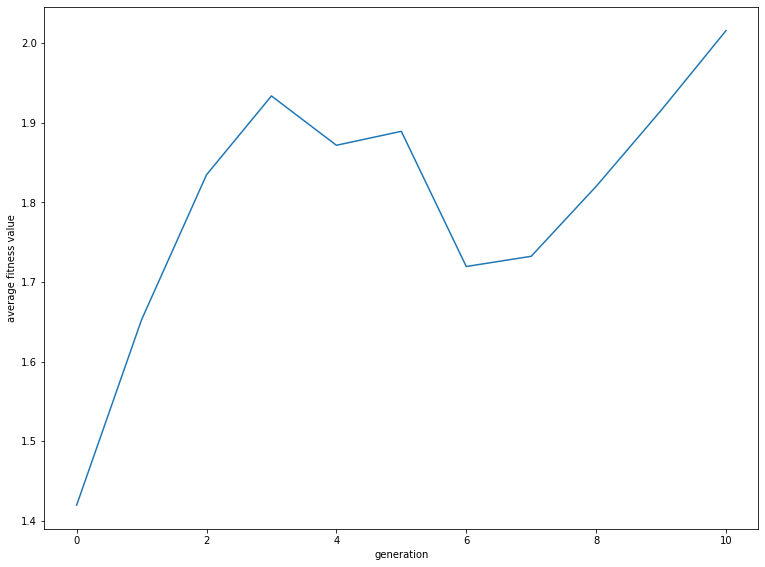

In [27]:
g_plot = np.arange(number_generations+1)
plt.figure(figsize=(12.8,9.6))
plt.plot(g_plot,f_gen)
plt.xlabel('generation')
plt.ylabel('average fitness value')
# plt.savefig('figures/ga-convergence-test.png')